# Neural networkds for time series
Using neural networks for time series analysis

In [8]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, SimpleRNN, LSTM
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from pandas.core.frame import DataFrame
from datetime import datetime

In [9]:
def load_dataset():
    ds = pd.read_csv('resources/hour.csv')
    ds['dteday'] = pd.to_datetime(ds['dteday'])
    return ds

def filter_by_date(ds: DataFrame, start_date: str, end_date: str):
    
    start_date_parsed = datetime.strptime(start_date, "%Y-%m-%d") 
    start_end_parsed = datetime.strptime(end_date, "%Y-%m-%d")
    
    return ds[(ds['dteday'] >= start_date_parsed) & (ds['dteday'] <= start_end_parsed)]
    
def one_hot_encoding(dataset, field):
    one_hot_encoded = pd.get_dummies(dataset[field])
    return  pd.concat([dataset.drop(field, axis=1), one_hot_encoded], axis=1)
    
def preprocess_dataset(ds):

    ds_reduced = ds[['dteday', 'cnt', 'season','yr','mnth','hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
    ds_reduced = one_hot_encoding(ds_reduced, 'season')
    ds_reduced = one_hot_encoding(ds_reduced, 'mnth')
    ds_reduced = one_hot_encoding(ds_reduced, 'hr')
    ds_reduced = one_hot_encoding(ds_reduced, 'weekday')
    ds_reduced = one_hot_encoding(ds_reduced, 'weathersit')
    
    return ds_reduced

def reshape_dataset(ds):

    Y = ds['cnt'].values
    
    ds_values = ds.drop(['dteday', 'cnt'], axis=1).values
    X = np.reshape(ds_values, (ds_values.shape[0], 1, ds_values.shape[1]))
    
    return X, Y

def get_model():

    #input = Input(shape=(1, 11))
    input = Input(shape=(1, 58))
    rnn = LSTM(500, dropout=.5)(input)
    activation = Dense(1, activation='linear')(rnn)

    model = Model(inputs=input, outputs=activation)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    return model

def train_model(model, X_train, Y_train, validation, callbacks):

    model.fit(X_train, Y_train, epochs=200, batch_size=128, validation_data=validation, callbacks=callbacks)
    return model

In [10]:
%matplotlib inline

import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [11]:
dataset = load_dataset()
dataset = preprocess_dataset(dataset)

train = filter_by_date(dataset, '2011-01-01', '2012-10-31')
dev = filter_by_date(dataset, '2012-11-01', '2012-11-30')

X_train, Y_train = reshape_dataset(train)
X_validation, Y_validation = reshape_dataset(dev)

model = train_model(get_model(), X_train, Y_train, (X_validation, Y_validation), [plot_losses])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 58)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               1118000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 1,118,501
Trainable params: 1,118,501
Non-trainable params: 0
_________________________________________________________________


In [5]:
def show_predict(model, X, Y):
    
    Y_predict = model.predict(X)
    
    plt.figure(figsize=(20,10))
    plt.plot(list(range(len(Y))), Y, label="Real")
    plt.plot(list(range(len(Y_predict))), Y_predict, label="Predicted")
    plt.legend()
    plt.show()
    
    return 

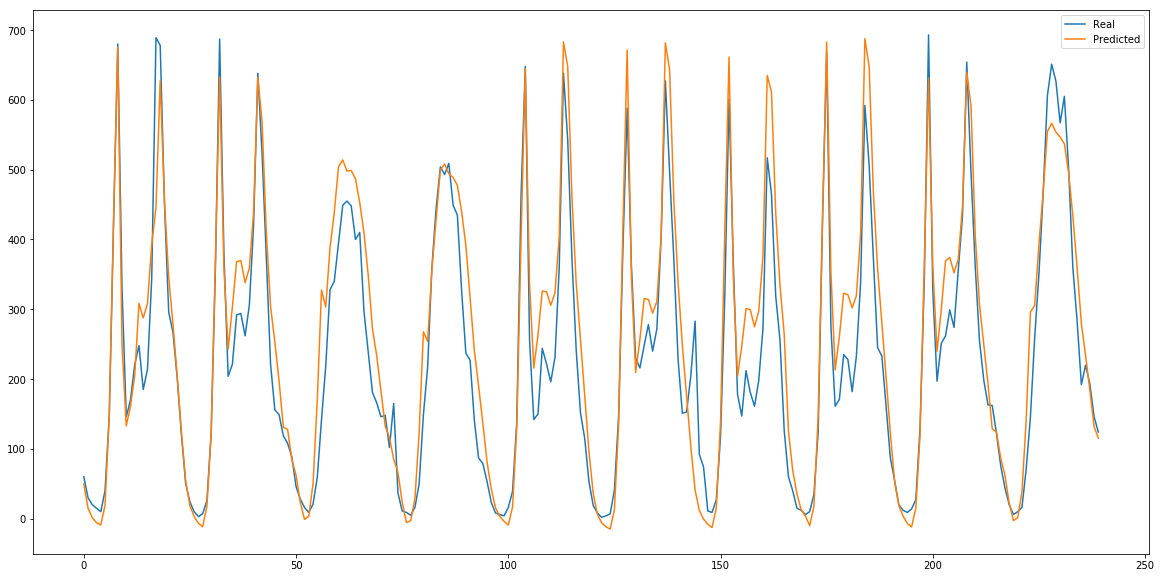

In [7]:
show_predict(model, X_validation[0:240], Y_validation[0:240])